In [1]:
import numpy as np
from keras import backend as K
import scipy
from skimage.measure import label, regionprops
from skimage.transform import resize
import os
from PIL import Image
from keras.preprocessing import image
import tensorflow as tf
from keras.optimizers import SGD
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,
    Activation, Conv2DTranspose, Multiply, Add, AveragePooling2D, Average
)
from keras.models import Model
import random
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
# Define helper functions
def mk_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

def return_list(data_path, data_type):
    file_list = [file for file in os.listdir(data_path) if file.lower().endswith(data_type)]
    print(str(len(file_list)))
    return file_list

def train_loader(data_list, data_path, mask_path, input_size):
    for lineIdx in range(len(data_list)):
        temp_txt = data_list[lineIdx]

        train_img = np.asarray(image.load_img(
            os.path.join(data_path, temp_txt),
            target_size=(input_size, input_size, 3))
        ).astype('float32')

        img_mask = np.asarray(image.load_img(
            os.path.join(mask_path, temp_txt),
            target_size=(input_size, input_size, 3))) / 255.0

        img_mask = img_mask.astype('float32')

        yield (train_img, (img_mask, img_mask, img_mask, img_mask, img_mask))


def tf_data_loader(data_list, data_path, mask_path, input_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: train_loader(data_list, data_path, mask_path, input_size),
        output_signature=(
            tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32),
            tuple([tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32)] * 5)
        )
    )
    return dataset

def pro_process(temp_img, input_size):
    img = np.asarray(temp_img).astype('float32')  # Ensure float32 dtype
    img = resize(img, (input_size, input_size, 3), preserve_range=True)  # Resize and preserve range
    return img

def BW_img(input, thresholding):
    if input.max() > thresholding:
        binary = input > thresholding
    else:
        binary = input > input.max()/2.0

    label_image = label(binary)
    regions = regionprops(label_image)
    area_list = []
    for region in regions:
        area_list.append(region.area)
    if area_list:
        idx_max = np.argmax(area_list)
        binary[label_image != idx_max+1] = 0
    return scipy.ndimage.binary_fill_holes(np.asarray(binary).astype(int))
    
def disc_crop(org_img, DiscROI_size, C_x, C_y):
    tmp_size = int(DiscROI_size/2)
    disc_region = np.zeros((DiscROI_size, DiscROI_size, 3), dtype= org_img.dtype)
    crop_coord = np.array([C_x-tmp_size, C_x+tmp_size, C_y-tmp_size, C_y+tmp_size], dtype= int)
    err_coord = [0, DiscROI_size, 0, DiscROI_size]

    if crop_coord[0] < 0:
        err_coord[0] = abs(crop_coord[0])
        crop_coord[0] = 0

    if crop_coord[2] < 0:
        err_coord[2] = abs(crop_coord[2])
        crop_coord[2] = 0

    if crop_coord[1] > org_img.shape[0]:
        err_coord[1] = err_coord[1] - (crop_coord[1] - org_img.shape[0])
        crop_coord[1] = org_img.shape[0]

    if crop_coord[3] > org_img.shape[1]:
        err_coord[3] = err_coord[3] - (crop_coord[3] - org_img.shape[1])
        crop_coord[3] = org_img.shape[1]

    disc_region[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ] = org_img[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ]

    return disc_region, err_coord, crop_coord

In [3]:
# Training Settings
result_path = mk_dir('/kaggle/working/output_deep_model/')
pre_model_file = '/kaggle/input/deep-model/deep_model/Model_MNet_REFUGE.h5'
save_model_file = result_path + 'Model_MNet_REFUGE_v2.keras'

root_path = '/kaggle/input/training-data-polar/training_crop/'
train_data_path = root_path + 'data/'
train_mask_path = root_path + 'label/'

val_data_path = root_path + 'val_data/data/'
val_mask_path = root_path + 'val_data/label/'

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

1400
300


In [4]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose, UpSampling2D
from keras.layers import  BatchNormalization, Activation, average

def DeepModel(size_set = 800):

    img_input = Input(shape=(size_set, size_set, 3))
    
    scale_img_2 = AveragePooling2D(pool_size=(2, 2))(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2))(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2))(scale_img_3)

    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu',name='block1_conv1')(img_input)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu',name='block1_conv2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    input2 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block2_input1')(scale_img_2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block2_conv1')(input2)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block2_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    input3 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block3_input1')(scale_img_3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block3_conv1')(input3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block3_conv2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    input4 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block4_input1')(scale_img_4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block4_conv1')(input4)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block4_conv2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu',name='block5_conv1')(pool4)
    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu',name='block5_conv2')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block6_conv1')(up6)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block6_conv2')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block7_conv1')(up7)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block7_conv2')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block8_conv1')(up8)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv2')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv1')(up9)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv2')(conv9)

    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(3, (1, 1), activation='softmax', name='side_63')(side6)
    out7 = Conv2D(3, (1, 1), activation='softmax', name='side_73')(side7)
    out8 = Conv2D(3, (1, 1), activation='softmax', name='side_83')(side8)
    out9 = Conv2D(3, (1, 1), activation='softmax', name='side_93')(conv9)

    out10 = average([out6, out7, out8, out9])

    model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9, out10])

    return model

input_size = 400

# Initialize the model
my_model = DeepModel(size_set=input_size)


In [5]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for multiclass segmentation.
    """
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denominator = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice_score = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - tf.reduce_mean(dice_score)

In [6]:
input_size = 224
batch_size = 8
epochs = 100  # Total number of epochs to train

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

# Create TensorFlow datasets
train_dataset = tf_data_loader(train_list, train_data_path, train_mask_path, input_size)
val_dataset = tf_data_loader(val_list, val_data_path, val_mask_path, input_size)

# Calculate steps per epoch
steps_per_epoch = len(train_list) // batch_size
validation_steps = len(val_list) // batch_size

# Prepare the datasets
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(train_list), reshuffle_each_iteration=True)
    .batch(batch_size)
    .repeat()  # Repeat indefinitely
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset
    .batch(batch_size)
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)


# Initialize the model
my_model = DeepModel(size_set=input_size)
my_model.load_weights('/kaggle/input/mnetrefugemodel-weights/Model_MNet_REFUGE_v2.keras')

# Define the optimizer
optimizer_setting = SGD(learning_rate=0.0001, momentum=0.9)

# Compile the model
my_model.compile(
    optimizer=optimizer_setting,
    loss=dice_loss,
    loss_weights=[0.1, 0.1, 0.1, 0.1, 0.6]
)


# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint(
    filepath=save_model_file,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

# Train the model
history = my_model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

1400
300
Epoch 1/100


I0000 00:00:1733891308.419021      92 service.cc:145] XLA service 0x7989a8002d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733891308.419077      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/175 ━━━━━━━━━━━━━━━━━━━━ 2:43:56 57s/step - loss: 0.5731

I0000 00:00:1733891320.591208      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_18', 792 bytes spill stores, 736 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_16', 808 bytes spill stores, 788 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_1', 100 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 76 bytes spill stores, 76 bytes spill loads

I0000 00:00:1733891320.602851      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.5798
Epoch 1: val_loss improved from inf to 0.57415, saving model to /kaggle/working/output_deep_model/Model_MNet_REFUGE_v2.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 152ms/step - loss: 0.5798 - val_loss: 0.5742
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.5781
Epoch 2: val_loss did not improve from 0.57415
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - loss: 0.5781 - val_loss: 0.5757
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.5774
Epoch 3: val_loss improved from 0.57415 to 0.57284, saving model to /kaggle/working/output_deep_model/Model_MNet_REFUGE_v2.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - loss: 0.5774 - val_loss: 0.5728
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.5770
Epoch 4: val_loss did not improve from 0.57284
175/175 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - loss: 0.5770 - val_loss: 0.5740
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.5763
Epoch 5

n0258_600.png
n0258_600.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


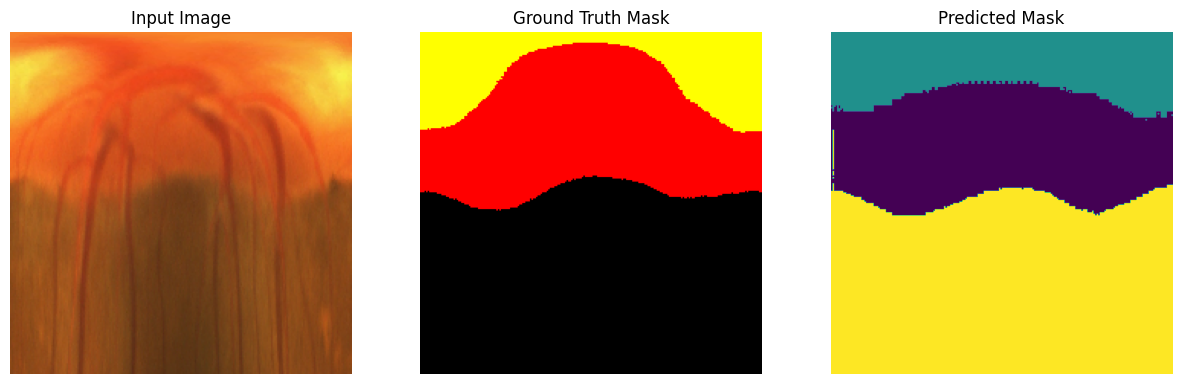

In [8]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
# Function to load a single image and mask
def load_single_image(img_path, mask_path, target_size):
    # Load and preprocess the image
    img = np.asarray(image.load_img(
        img_path,
        target_size=(target_size, target_size, 3))
    )
    
    # Load and preprocess the mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size))
    
    img_mask = np.asarray(img_mask).astype('int32')
    
    return img, img_mask

# Select a sample from the validation set
sample_index = 0
sample_img_name = val_list[sample_index]
sample_mask_name = val_list[sample_index]  # Assuming mask filenames are the same as image filenames

sample_img_path = os.path.join(val_data_path, sample_img_name)
sample_mask_path = os.path.join(val_mask_path, sample_mask_name)

print(sample_img_name)
print(sample_mask_name)

# Load the image and mask
input_size = 224  # Ensure this matches your model's expected input size
img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
predictions = my_model.predict(img_input)
final_output = predictions[-1][0]  # Extract the first sample from the batch

# Since the model outputs softmax probabilities over 3 classes, take the argmax to get predicted class labels
predicted_mask = np.argmax(final_output, axis=-1)


# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img/255.0)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

In [9]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to load a single image and mask
def load_single_image(img_path, mask_path, target_size):
    # Load and preprocess the image
    img = np.asarray(image.load_img(
        img_path,
        target_size=(target_size, target_size, 3))
    ).astype('float32')

    # Load and preprocess the mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size),
        color_mode='grayscale')

    img_mask = np.asarray(img_mask).astype('int32')

    return img, img_mask

# Function to remap mask values to discrete classes {0, 1, 2}
def remap_mask_values(mask):
    value_mapping = {
        0: 2,    # Background
        76: 0,   # Disc
        225: 1,
        226: 1   # Cup
    }
    
    # Default value for undefined keys
    default_value = 0  # Treat unexpected values as background if not found
    remapped_mask = np.vectorize(lambda x: value_mapping.get(x, default_value))(mask)
    
    return remapped_mask

# Function to calculate confusion matrix components for a given class
def calculate_class_confusion(predicted_mask, ground_truth_mask, target_class):
    # Flatten the arrays for comparison
    pred_flat = (predicted_mask == target_class).flatten().astype(int)
    gt_flat = (ground_truth_mask == target_class).flatten().astype(int)
    
    # Calculate confusion matrix components
    TP = np.sum((pred_flat == 1) & (gt_flat == 1))  # True Positives
    TN = np.sum((pred_flat == 0) & (gt_flat == 0))  # True Negatives
    FP = np.sum((pred_flat == 1) & (gt_flat == 0))  # False Positives
    FN = np.sum((pred_flat == 0) & (gt_flat == 1))  # False Negatives

    return TP, TN, FP, FN

# Function to calculate metrics given accumulated confusion components
def compute_metrics_from_confusion(TP, TN, FP, FN):
    # Sensitivity (Sen) and Specificity (Spe)
    Sen = TP / (TP + FN) if (TP + FN) > 0 else 0
    Spe = TN / (TN + FP) if (TN + FP) > 0 else 0

    # Overlap metrics
    intersection = TP  # intersection is basically TP for the binary class scenario
    union = TP + FP + FN
    E = 1 - (intersection / union) if union > 0 else 1  # Error
    A = 0.5 * (Sen + Spe)  # Balanced accuracy

    return Sen, Spe, E, A

# Calculate metrics over the whole validation set
def calculate_metrics_over_validation(val_list, val_data_path, val_mask_path, model, input_size=224):
    # Classes: 0 (Disc), 1 (Cup), 2 (Background)
    # We'll accumulate TP, TN, FP, FN for each class
    # For clarity, let's define indices as: 0->Disc, 1->Cup, 2->Background.
    
    class_labels = [0, 1, 2]
    
    # Initialize accumulators
    class_accumulators = {
        cls: {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
        for cls in class_labels
    }
    
    # Iterate over the entire validation set
    for i, img_name in enumerate(val_list):
        mask_name = img_name  # Assuming same filename for mask
        sample_img_path = os.path.join(val_data_path, img_name)
        sample_mask_path = os.path.join(val_mask_path, mask_name)
        
        # Load the image and mask
        img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
        img_input = np.expand_dims(img, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(img_input)
        final_output = predictions[-1][0]  # Extract the first sample's output
        predicted_mask = np.argmax(final_output, axis=-1)

        # Remap ground truth mask values if necessary
        ground_truth_mask = remap_mask_values(mask)

        # Accumulate confusion values for each class
        for cls in class_labels:
            TP, TN, FP, FN = calculate_class_confusion(predicted_mask, ground_truth_mask, cls)
            class_accumulators[cls]["TP"] += TP
            class_accumulators[cls]["TN"] += TN
            class_accumulators[cls]["FP"] += FP
            class_accumulators[cls]["FN"] += FN

    # After processing the whole dataset, compute the final metrics
    final_metrics = {}
    for cls in class_labels:
        TP = class_accumulators[cls]["TP"]
        TN = class_accumulators[cls]["TN"]
        FP = class_accumulators[cls]["FP"]
        FN = class_accumulators[cls]["FN"]

        Sen, Spe, E, A = compute_metrics_from_confusion(TP, TN, FP, FN)
        final_metrics[f"Class {cls}"] = {
            "Sensitivity (Sen)": Sen,
            "Specificity (Spe)": Spe,
            "Error (E)": E,
            "Balanced Accuracy (A)": A,
            "TP": TP,
            "TN": TN,
            "FP": FP,
            "FN": FN
        }

    return final_metrics

# Example usage:
all_metrics = calculate_metrics_over_validation(val_list, val_data_path, val_mask_path, my_model, input_size=224)
for cls, metrics in all_metrics.items():
     print(f"\nMetrics for {cls}:")
     for key, value in metrics.items():
         print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━